n01641577

0.038738*agama * newt_0.7465035.jpg


In [59]:
import torchvision

image = torchvision.io.read_image(
    "datasets/imagenet-a/n01641577/0.038738_agama _ newt_0.7465035.jpg"
)

# image_batch = image.float().div(255).unsqueeze(0).repeat(63, 1, 1, 1)
image_batch = image.float().div(255).repeat(63, 1, 1, 1)

In [60]:
import torch
import kornia.augmentation as K
import numpy as np
from typing import List, Optional
from torch import nn
import kornia.enhance as Ke


class RandomEqualize(nn.Module):
    def __init__(self, p: float = 0.5, same_on_batch: bool = False):
        """
        Random histogram equalization using Kornia's equalize

        Args:
            p: probability of applying the transform
            same_on_batch: apply same transform across the batch
        """
        super().__init__()
        self.p = p
        self.same_on_batch = same_on_batch
        self.equalize = Ke.equalize

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        if self.p == 0:
            return input

        batch_size = input.shape[0]

        # Generate random mask
        if self.same_on_batch:
            rand_mask = torch.rand(1, device=input.device) < self.p
            rand_mask = rand_mask.expand(batch_size)
        else:
            rand_mask = torch.rand(batch_size, device=input.device) < self.p

        if rand_mask.any():
            output = input.clone()
            output[rand_mask] = self.equalize(input[rand_mask])
            return output

        return input


class AugMixKornia:
    def __init__(
        self,
        severity: int = 3,
        width: int = 3,
        depth: int = -1,
        alpha: float = 1.0,
        mixture_width: int = 3,
        chain_depth: int = 3,
        all_ops: bool = True,
        device: Optional[str] = None,
    ):
        self.severity = severity
        self.width = width
        self.depth = depth
        self.alpha = alpha
        self.mixture_width = mixture_width
        self.chain_depth = chain_depth
        self.all_ops = all_ops
        self.device = device or ("cuda" if torch.cuda.is_available() else "cpu")

        # Define augmentation operations
        self.augmentations = self._get_augmentations()

    def _get_augmentations(self) -> List[K.AugmentationSequential]:
        """Create a list of augmentation sequences that will be randomly applied"""
        # Convert severity to parameter ranges
        severity_factor = self.severity / 10.0

        # Add equalization to the augmentation list
        equalize_aug = K.AugmentationSequential(
            RandomEqualize(
                p=1.0,
                same_on_batch=False,
            ),
            same_on_batch=False,
        ).to(self.device)

        if self.all_ops:
            aug_list = [
                # AutoContrast-like
                K.AugmentationSequential(
                    K.ColorJitter(
                        brightness=(0.05 * self.severity, 0.1 * self.severity),
                        contrast=(0.05 * self.severity, 0.1 * self.severity),
                        p=1.0,
                    ),
                    same_on_batch=False,  # Different params per image
                ).to(self.device),
                # Equalize
                equalize_aug,
                # Posterize
                K.AugmentationSequential(
                    K.RandomPosterize(bits=max(1, 8 - self.severity), p=1.0),
                    same_on_batch=False,
                ).to(self.device),
                # Rotate
                K.AugmentationSequential(
                    K.RandomRotation(
                        degrees=(-30 * severity_factor, 30 * severity_factor), p=1.0
                    ),
                    same_on_batch=False,
                ).to(self.device),
                # Solarize
                K.AugmentationSequential(
                    K.RandomSolarize(
                        thresholds=0.5, additions=(0.0, 0.1 * self.severity), p=1.0
                    ),
                    same_on_batch=False,
                ).to(self.device),
                # Shear
                K.AugmentationSequential(
                    K.RandomAffine(
                        degrees=0,
                        shear=(-15 * severity_factor, 15 * severity_factor),
                        p=1.0,
                    ),
                    same_on_batch=False,
                ).to(self.device),
                # Translate
                K.AugmentationSequential(
                    K.RandomAffine(
                        degrees=0,
                        translate=(0.1 * severity_factor, 0.1 * severity_factor),
                        p=1.0,
                    ),
                    same_on_batch=False,
                ).to(self.device),
            ]
        else:
            # Simplified version with fewer ops
            aug_list = [
                K.AugmentationSequential(
                    K.ColorJitter(
                        brightness=0.1 * self.severity,
                        contrast=0.1 * self.severity,
                        saturation=0.1 * self.severity,
                        hue=0.1,
                        p=1.0,
                    ),
                    same_on_batch=False,
                ).to(self.device),
                equalize_aug,
                K.AugmentationSequential(
                    K.RandomAffine(
                        degrees=(-15 * severity_factor, 15 * severity_factor),
                        translate=(0.1 * severity_factor, 0.1 * severity_factor),
                        p=1.0,
                    ),
                    same_on_batch=False,
                ).to(self.device),
            ]
        return aug_list

    def _apply_augmentation_chain(
        self, images: torch.Tensor, depths: torch.Tensor
    ) -> torch.Tensor:
        """
        Apply random augmentation chains to each image in the batch
        Args:
            images: batch of images (B, C, H, W)
            depths: augmentation depth for each image (B,)
        Returns:
            augmented images (B, C, H, W)
        """
        batch_size = images.shape[0]
        results = torch.zeros_like(images)

        for i in range(batch_size):
            # Select random augmentations for this image
            op_indices = torch.randint(
                low=0,
                high=len(self.augmentations),
                size=(depths[i],),
                device=self.device,
            )

            # Apply augmentation chain
            augmented = images[i].unsqueeze(0)  # Add batch dim
            for op_idx in op_indices:
                aug = self.augmentations[op_idx.item()]
                augmented = aug(augmented)

            results[i] = augmented.squeeze(0)

        return results

    def __call__(self, images: torch.Tensor) -> torch.Tensor:
        """
        Apply AugMix to a batch of images with different random effects per image
        Args:
            images: batch of images (B, C, H, W) or (C, H, W)
        Returns:
            augmented batch (same shape as input)
        """
        # Input validation
        if not isinstance(images, torch.Tensor):
            images = K.image_to_tensor(images)

        if images.dim() == 3:
            images = images.unsqueeze(0)

        # Move to device if needed
        if images.device != self.device:
            images = images.to(self.device)

        batch_size = images.shape[0]

        # Sample mixing weights (different per image)
        alphas = torch.tensor(
            np.random.gamma(self.alpha, 1.0, size=batch_size),
            dtype=torch.float32,
            device=self.device,
        ).view(
            -1, 1, 1, 1
        )  # Shape (B, 1, 1, 1)

        # Sample augmentation depths (different per image)
        depths = torch.randint(
            low=1,
            high=self.chain_depth + 1 if self.depth <= 0 else self.depth + 1,
            size=(batch_size,),
            device=self.device,
        )

        # Generate mixed augmented images
        mix = torch.zeros_like(images)
        for _ in range(self.mixture_width):
            # Apply augmentation chains (different for each image)
            augmented = self._apply_augmentation_chain(images, depths)

            # Sample new weights for this mixture component
            component_weights = torch.tensor(
                np.random.gamma(self.alpha, 1.0, size=batch_size),
                dtype=torch.float32,
                device=self.device,
            ).view(-1, 1, 1, 1)

            # Accumulate weighted sum
            mix += component_weights * augmented

        # Normalize and mix with original
        mix = mix / self.mixture_width
        result = (1 - alphas) * images + alphas * mix

        return result.squeeze(0) if result.shape[0] == 1 else result

In [61]:
kornia_augmix = AugMixKornia(severity=3, device="cuda", all_ops=True)
augmented_images = kornia_augmix(image_batch)

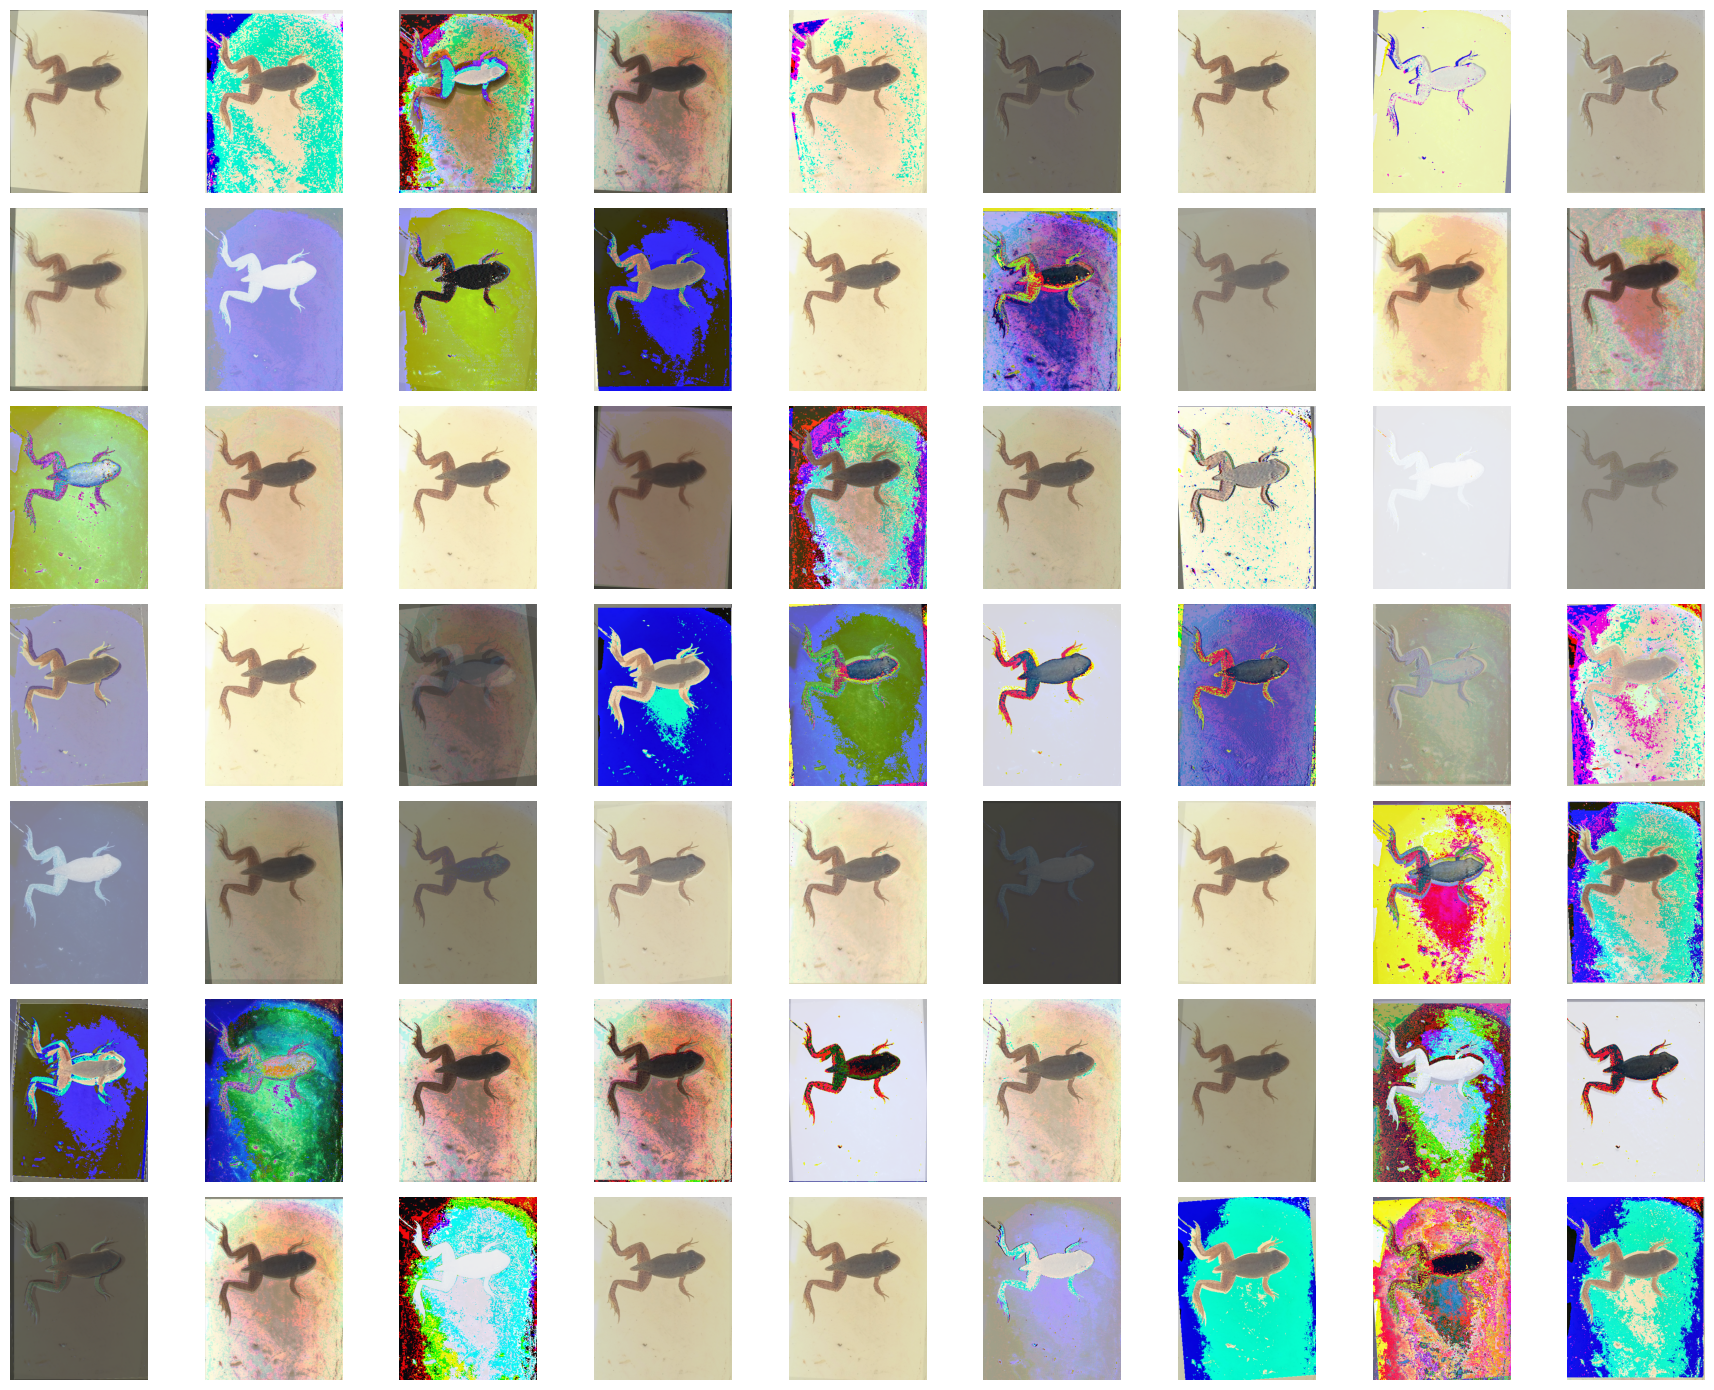

In [62]:
plot_images(augmented_images)

In [50]:
# Same on augmix
augmix = torchvision.transforms.AugMix()
augmented_augmix = [augmix(image) for _ in range(63)]
augmented_augmix = torch.stack(augmented_augmix)
augmented_augmix.shape

torch.Size([63, 3, 500, 375])

In [6]:
# visualize images

import torch
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF


def plot_images(images):
    cols = 9
    rows = (images.shape[0] + cols - 1) // cols

    plt.figure(figsize=(cols * 2, rows * 2))
    for i in range(images.shape[0]):
        img = images[i]
        img = TF.to_pil_image(img)  # Convert from [C, H, W] to PIL image

        plt.subplot(rows, cols, i + 1)
        plt.imshow(img)
        plt.axis("off")

    plt.tight_layout()
    plt.show()

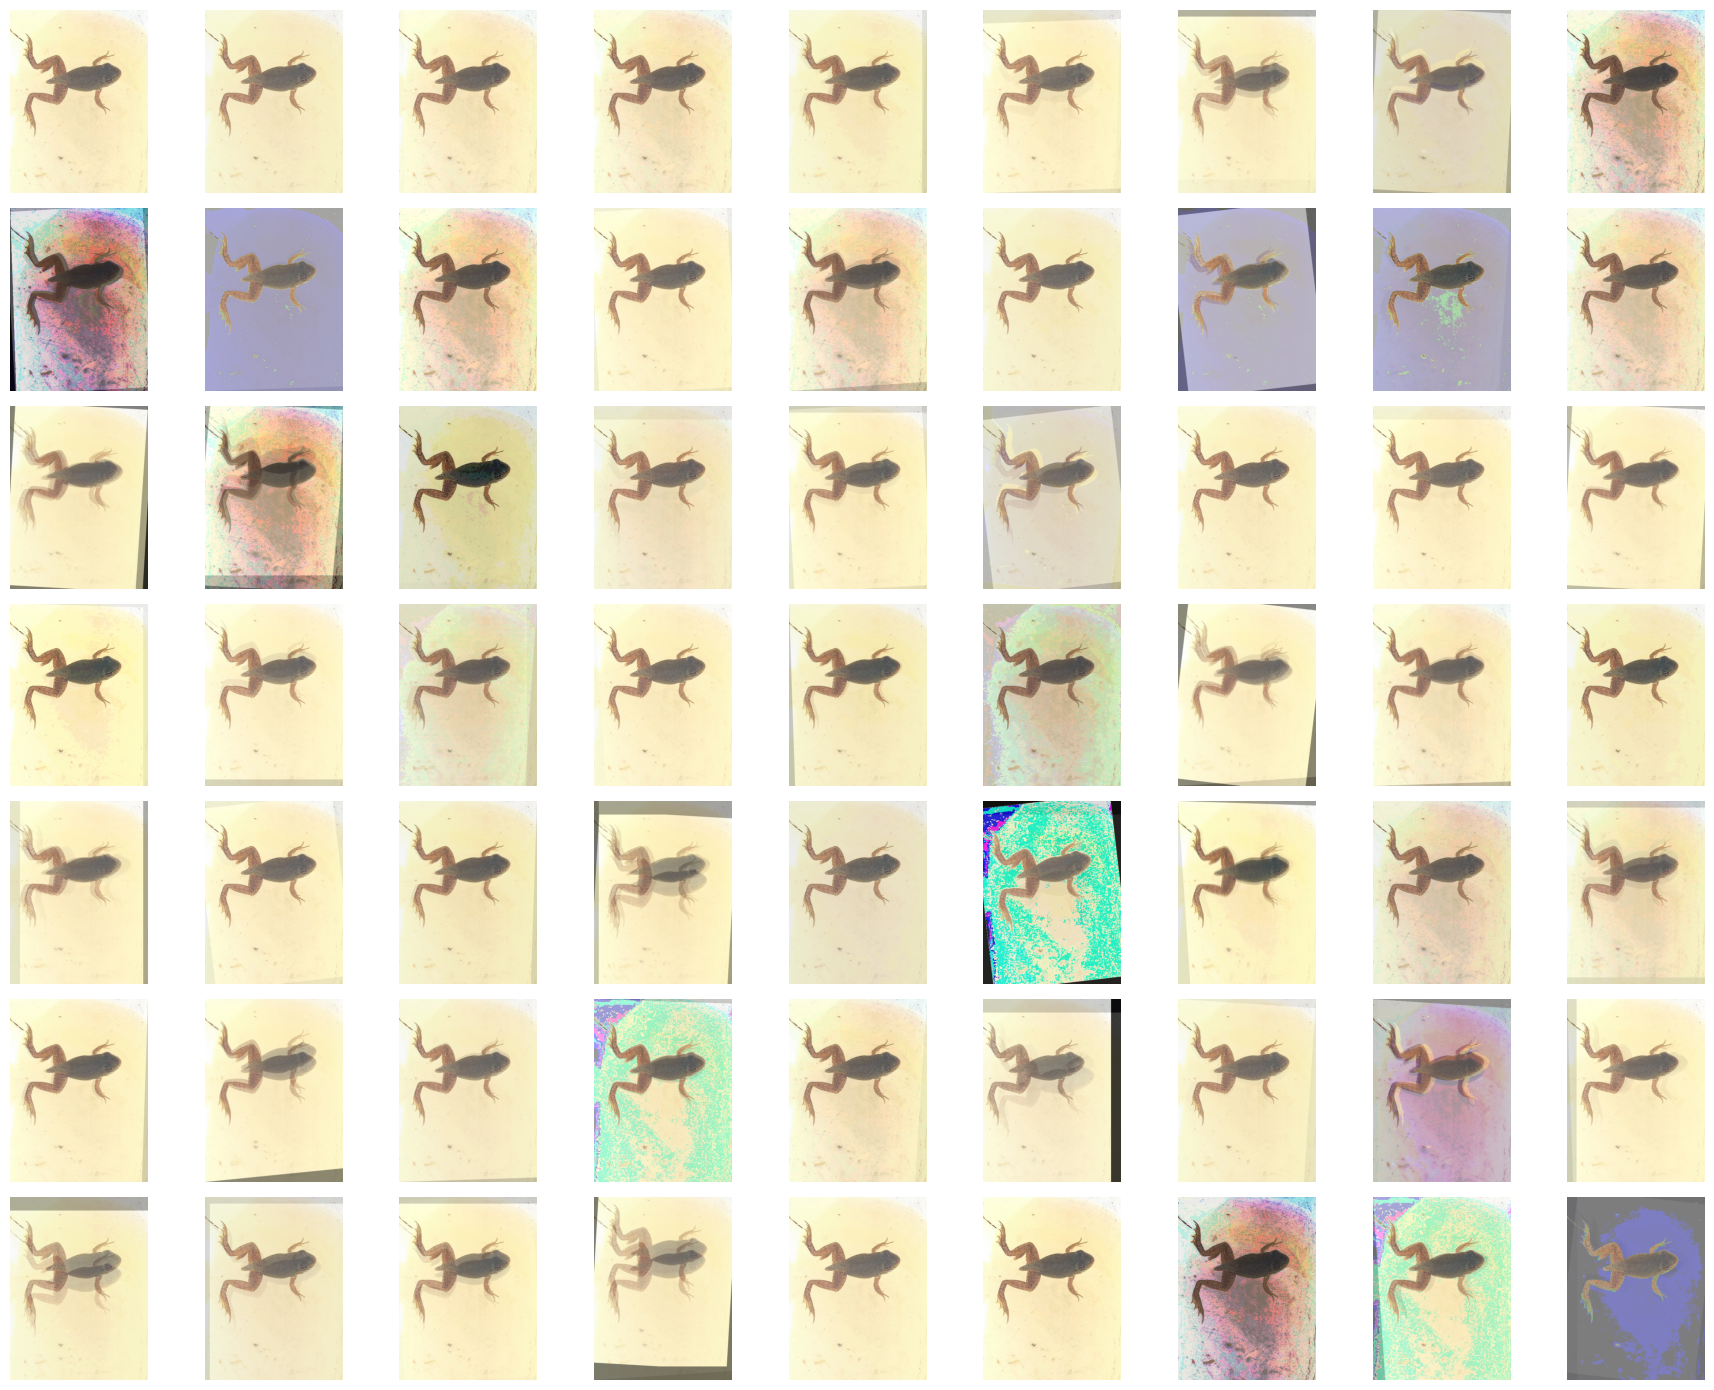

In [28]:
plot_images(augmented_augmix)